mettere best kentel del evaluTE

In [1]:
%pip install pandas numpy matplotlib scikit-learn scipy pymoo seaborn forestci 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\aless\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from itertools import product
from datetime import datetime
import numpy as np
from sklearn.preprocessing    import StandardScaler, KBinsDiscretizer
from sklearn.model_selection  import train_test_split, KFold
from sklearn.metrics          import mean_squared_error, r2_score, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble         import RandomForestRegressor
import xgboost                 as xgb
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import cdist
import forestci as fci

from sklearn.gaussian_process.kernels import Matern, ConstantKernel, WhiteKernel, DotProduct, RBF, RationalQuadratic

from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from pymoo.problems.many import DTLZ2
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from scipy.stats import entropy
from itertools import product  
# Problem Definition
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)

def scalarized_objective(x, lam, problem):
    f = problem.evaluate(np.array([x]))[0]
    return np.dot(lam, f)

def stratified_split(X, y, n_bins=10, test_size=0.2, random_state=42):
    """
    Stratifica lo split train/test basandosi su binning di λ₁.
    """
    # Applica binning su λ₁
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    stratify_labels = discretizer.fit_transform(X[:, 0].reshape(-1, 1)).ravel()  # Binning su λ₁

    # Split stratificato
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_labels
    )
    return X_train, X_test, y_train, y_test

def diversity_enhanced_ei(lambda_candidates, model, X_scaler, y_best_scaled, top_k=100, w_ei=1.0, w_div=0.1, w_sigma=0.5):
    X_cand_scaled = X_scaler.transform(lambda_candidates)
    mu, sigma = model.predict(X_cand_scaled, return_std=True)
    with np.errstate(divide='warn'):
        imp = mu.reshape(-1, 1) - y_best_scaled
        Z = imp / sigma.reshape(-1, 1)
        ei = imp * norm.cdf(Z) + sigma.reshape(-1, 1) * norm.pdf(Z)
        ei = ei.ravel()
    dist_matrix = cdist(lambda_candidates, lambda_candidates)
    diversity_score = dist_matrix.mean(axis=1)
    combined_score = w_ei * ei + w_div * diversity_score + w_sigma * sigma
    top_idx = np.argsort(-combined_score)[:top_k]
    return lambda_candidates[top_idx]

def active_learning_with_ei(model, X_scaler, y_scaler, lambda_grid, dataset, top_k=10):
    """
    Usa Expected Improvement (EI) per selezionare nuovi punti λ e aggiorna il dataset.
    """
    # Calcola il miglior valore corrente di y (minimizzazione)
    y_best_scaled = np.min(dataset["frob_norm"].values)

    # Seleziona i nuovi punti λ con EI
    lambda_selected = diversity_enhanced_ei(
        lambda_candidates=lambda_grid,
        model=model,
        X_scaler=X_scaler,
        y_best_scaled=y_best_scaled,
        top_k=top_k,
        w_ei=1.0,
        w_div=0.1,
        w_sigma=0.5
    )

    # Aggiorna il dataset con i nuovi punti λ
    updated_dataset = update_dataset_with_new_data(lambda_selected, dataset)
    return updated_dataset

def update_dataset_with_new_data(lambda_selected, dataset, base_filename="updated_dataset", window_size=10):
    # Calcola n_vars e n_obj dal dataset

    n_vars = problem.n_var
    n_obj = problem.n_obj

    new_x_star, new_frob_norms, new_variances, new_P_vectors = [], [], [], []
    for lam in lambda_selected:
        # Assicurati che n_vars sia definito correttamente
        res = minimize(scalarized_objective, x0=np.full(n_vars, 0.5), args=(lam, problem), method='L-BFGS-B', bounds=[(0.0, 1.0)] * n_vars)
        x_opt = res.x
        new_x_star.append(x_opt)
        if len(new_x_star) >= 2 :
            X_local = StandardScaler().fit_transform(np.array(new_x_star[-window_size:]))
            C = np.cov(X_local.T) + np.eye(n_vars) * 1e-8
            new_frob_norms.append(np.linalg.norm(C, ord='fro'))
            new_variances.append(np.var(X_local, axis=0))
            P = np.linalg.cholesky(C)
            new_P_vectors.append(P[np.tril_indices_from(P)])
        else:
            new_frob_norms.append(np.nan)
            new_variances.append(np.full(n_vars, np.nan))
            new_P_vectors.append(np.full((n_vars * (n_vars + 1)) // 2, np.nan))

    new_data_dict = {f"lambda_{i+1}": lambda_selected[:, i] for i in range(n_obj)}
    new_data_dict["frob_norm"] = new_frob_norms
    for i in range(n_vars):
        new_data_dict[f"x_star_{i+1}"] = [x[i] for x in new_x_star]
        new_data_dict[f"var_x_star_{i+1}"] = [v[i] for v in new_variances]
    for i in range(len(new_P_vectors[0])):
        new_data_dict[f"P_vec_{i+1}"] = [p[i] for p in new_P_vectors]
    new_data_dict["source"] = ["EI_selected"] * len(lambda_selected)

    new_df = pd.DataFrame(new_data_dict)
    updated_dataset = pd.concat([dataset, new_df], ignore_index=True)
    updated_dataset = updated_dataset.dropna(subset=["frob_norm"])

    # Salva il dataset aggiornato con un nome unico
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    new_filename = f"{base_filename}_{timestamp}.csv"
    updated_dataset.to_csv(new_filename, index=False)
    print(f"Dataset aggiornato salvato come: {new_filename}")

    return updated_dataset

def evaluate_on_test(gpr, X_test, y_test, y_scaler):
    y_pred, y_std = gpr.predict(X_test, return_std=True)
    y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    scale = y_scaler.scale_[0] if y_scaler.scale_.shape else y_scaler.scale_

    print("[Test Evaluation]")
    print("RMSE:", np.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
    print("R2:", r2_score(y_test_inv, y_pred_inv))
    print("MAE:", mean_absolute_error(y_test_inv, y_pred_inv))

    plt.figure(figsize=(7, 6))
    plt.errorbar(y_test_inv, y_pred_inv.ravel(), yerr=y_std * scale, fmt='o', alpha=0.6)
    plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')
    plt.title("GP Prediction vs True ‖C(λ)‖_F")
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



def train_gp(X, y, best_kernel, verbose=True):
    if verbose:
        print("[GP Training] Inizio addestramento del modello...")
        print(f"Kernel utilizzato: {best_kernel}")
  
    model = GaussianProcessRegressor(kernel=best_kernel, n_restarts_optimizer=20, alpha=1e-3, normalize_y=True, random_state=42)
    model.fit(X, y)
    if verbose:
        print("[GP Training] Addestramento completato.")
        print(f"Log-Marginal-Likelihood del modello: {model.log_marginal_likelihood_value_:.4f}")
    
    return model

def select_best_kernel(X_train, y_train, verbose=True):
    kernels = [
    
    ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5),
    ConstantKernel(1.0) * DotProduct() + WhiteKernel(),
    ConstantKernel(1.0) * (RBF(length_scale=1.0) + WhiteKernel()),
    ConstantKernel(1.0) * RBF(length_scale=1.0) + Matern(length_scale=1.0, nu=1.5),
    ConstantKernel(1.0) * (RationalQuadratic() + Matern(nu=1.5)) + WhiteKernel()
]
    
    best_score = -np.inf
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    if verbose:
        print("[Kernel Selection] Inizio selezione del kernel...")

    for kernel_idx, kernel in enumerate(kernels):
        scores = []
        mae_scores = []  # Per memorizzare il MAE sui dati di validazione
        if verbose:
            print(f"\n[Kernel {kernel_idx + 1}/{len(kernels)}] Testando kernel: {kernel}")

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            X_tr, X_val = X_train[train_idx], X_train[val_idx]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            # Addestramento del modello
            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, normalize_y=True)
            model.fit(X_tr, y_tr)

            # Calcolo del log-marginal-likelihood
            log_likelihood = model.log_marginal_likelihood_value_
            scores.append(log_likelihood)

            # Predizione sui dati di validazione
            y_pred = model.predict(X_val)
            mae = mean_absolute_error(y_val, y_pred)
            mae_scores.append(mae)

            if verbose:
                print(f"  [Fold {fold_idx + 1}] Log-Likelihood: {log_likelihood:.4f}, MAE: {mae:.4f}")

        avg_score = np.mean(scores)
        avg_mae = np.mean(mae_scores)  # Media del MAE

        if verbose:
            print(f"[Kernel {kernel_idx + 1}] Log-Likelihood medio: {avg_score:.4f}, MAE medio: {avg_mae:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_kernel = kernel
            if verbose:
                print(f"  [Kernel {kernel_idx + 1}] Miglior kernel trovato finora!")

    if verbose:
        print(f"\n[Kernel Selection] Kernel migliore: {best_kernel} con Log-Likelihood medio: {best_score:.4f}")

    return best_kernel



[Data Preparation]


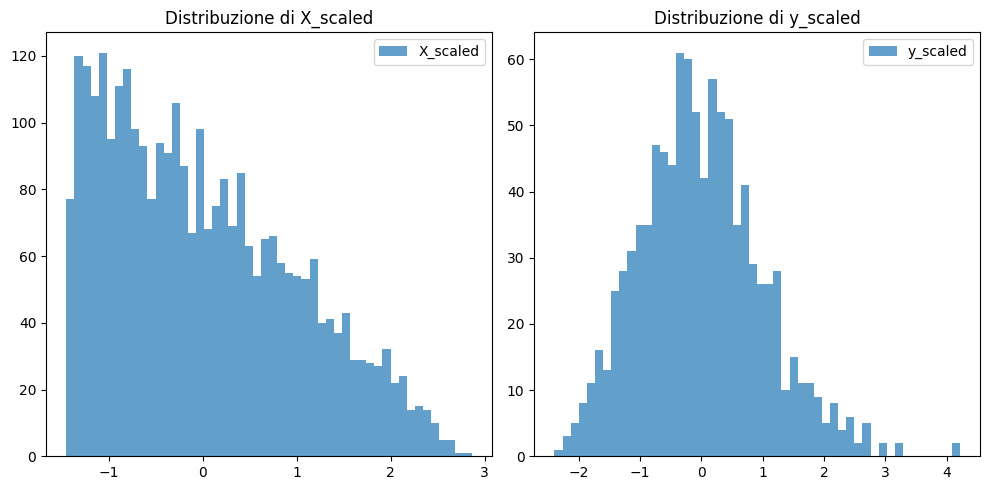

[Initial GP Training]
[GP Training] Inizio addestramento del modello...
Kernel utilizzato: 1**2 * RationalQuadratic(alpha=1, length_scale=1) + Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1)
[GP Training] Addestramento completato.
Log-Marginal-Likelihood del modello: -1135.1508
[Test Evaluation]
RMSE: 0.07018319018265373
R2: -0.009965348894710901
MAE: 0.05663718476043166


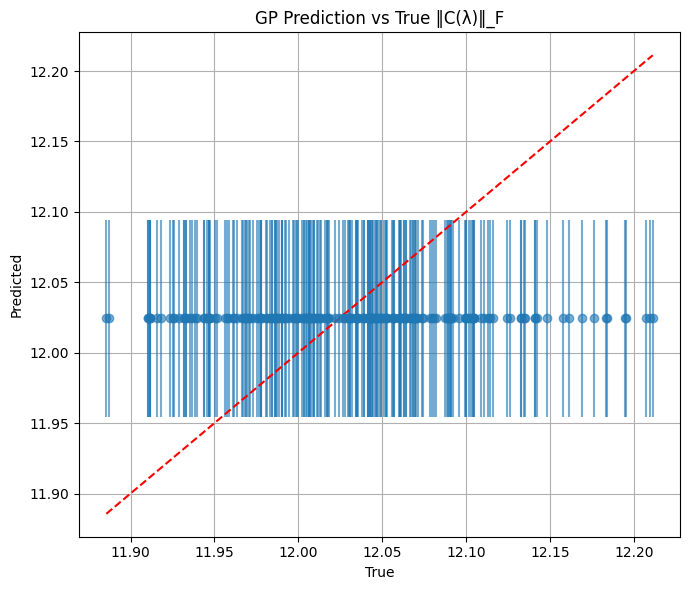

KeyboardInterrupt: 

In [3]:
print("[Data Preparation]")
df = pd.read_csv("dtlz2_dataset_balanced0.csv").dropna(subset=["frob_norm"])
n_obj = 3
k = 20
n_vars = n_obj + k - 1
problem = DTLZ2(n_var=n_vars, n_obj=n_obj)
X = df[["lambda_1", "lambda_2", "lambda_3"]].values
y = df["frob_norm"].values.reshape(-1, 1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = stratified_split(X, y, n_bins=10, test_size=0.2, random_state=42)


X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X_scaled = X_scaler.transform(X)
y_scaled = y_scaler.transform(y).ravel()


print("[Initial GP Training]")
default_kernel = ConstantKernel(1.0) * (RationalQuadratic() + Matern(nu=1.5)) + WhiteKernel()
gpr = train_gp(X_train, y_train, best_kernel=default_kernel, verbose=True)
evaluate_on_test(gpr, X_test, y_test, y_scaler)

from itertools import product

dataset_memory = df.copy()
step = 0.01  # Passo per la griglia
grid = np.arange(0, 1 + step, step)  # Crea punti della griglia
lambda_grid = np.array([lam for lam in product(grid, repeat=3) if np.isclose(sum(lam), 1)])  # Filtra vettori che sommano a 1
for iteration in range(1):
    print(f"\n=== Iteration {iteration+1}/5 ===")
    y_best_scaled = np.min(y_train)
    lambda_selected = diversity_enhanced_ei(lambda_candidates=lambda_grid,model=gpr,X_scaler=X_scaler,y_best_scaled=np.min(y_train),top_k=100,w_ei=1.0,w_div=1.0, w_sigma=1.5)
    
    dataset_memory = update_dataset_with_new_data(lambda_selected, dataset_memory)
    X = dataset_memory[["lambda_1", "lambda_2", "lambda_3"]].values
    y = dataset_memory[["frob_norm"]].values

    X_scaler = StandardScaler().fit(X)
    y_scaler = StandardScaler().fit(y)

    X_train = X_scaler.transform(X)
    y_train = y_scaler.transform(y).ravel()
    print(f"Dimensioni dei dati di addestramento: {X_train.shape}, {y_train.shape}")
    best_kernel = select_best_kernel(X_train, y_train, verbose=True)
    gpr = train_gp(X_train, y_train, best_kernel=best_kernel, verbose=True)
    print(f"Log-Likelihood durante l'addestramento finale: {gpr.log_marginal_likelihood_value_}")
    evaluate_on_test(gpr,X_test, y_test, y_scaler)